# Background
Depression is a serious mental health concern with numerous externalities, both on an individual and societal level. It would benefit  countries to try and determine what level of depression they may expect in the future. Like other mental illnesses there are a variety of factors, both enviromental and genetic, that contribute to this crisis so a variety of variables are necessary to predict what the future may hold accurately. 

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Methodology
Using Datasets collected from the World Bank, UN, WHO, World Value Surveys, and IMF, I plan on predicting the number of depression cases in the population two years after an observed country within a given year. For this model I will be examining the years of 1988 to 2015 to train this model. The relavent variables will take into account climate factors, presently being determined by average sunshine hours per year and whether or not an el nino weather pattern was observed that year. This will be combined with economic variables like the consumer price index and dummy years for economic crashes, namely 2008, 2000, 1993, and 1988. These will be coupled with demographic infromation based on WVS results by country for each time period which will aggregate each country's average response. This combined table will then be split into training and testing groups, split 80-20. 

In [2]:
#load in data
nino = pd.read_csv("nino.csv", keep_default_na=False, na_values=["NaN"])
depress = pd.read_excel('depression.xlsx')
clsunshine = pd.read_excel('cl_Sunshine.xlsx')
econ = pd.read_excel('econ.xlsx')

# Set seed
np.random.seed(2)

#fold generated with 6 folds
fold_generator = KFold(n_splits=6, shuffle=True,random_state=111)

In [3]:
#scale variable for easier use
depress['cleaned Depression'] = depress['Total Depressive disorders']/100000
clsunshine['clNational Annual Avg'] = clsunshine['National Annual Avg']/200
#create polynomial
depress['sqrCPI(% Annual)'] = depress['CPI(% Annual)'] **2
#change names to make merging easier
depress['Country'] = depress['Entity']
clsunshine['Country'] = clsunshine['Country or Territory']
#lag the depression variable
depress['Year'] = depress['Year'] - 2


In [4]:
# Left Join on the year.  We get all the rows from the left dataframe and the matching values from right.
# if there is no matching on the right, we get Null on the left (but that is not the case in this specific example)
dta = pd.merge(depress, nino, on='Year', how='left')
dta = pd.merge(dta, econ, on='Year', how='left')
dta = pd.merge(dta,clsunshine, on='Country', how='left')

In [5]:
# break the data up into a training (80%) and test dataset (20%). 

# Train-Test split (using Pandas)
train = dta.sample(frac=.8).reset_index(drop=True)
test = dta.drop(train.index).reset_index(drop=True)
print(test.shape[0],train.shape[0])
dtrain = train.dropna()
dtest = test.dropna()
print(dtest.shape[0],dtrain.shape[0])


1294 5174
341 1420


# Preliminary Results
Thus far I have run a pipe with Linear Model, NaiveBayes, KNN, Decision Tree, Bagging, and Random forest models. With the few variables I have wrangled into the models thus far I am finding that a linear model is the best predictor with the most predictive variable being the annual average amount of sunshine hours. This may be due to endogeniety issues relating to developing countries or possibly be a result of outlier values.

In [12]:
# generate x values
train_x = dtrain.drop(columns=['Total Depressive disorders','Code','Entity','Year',
'cleaned Depression','Country or Territory','Country','National Annual Avg'])
test_x = dtest.drop(columns=['Total Depressive disorders','Code','Entity','Year',
'cleaned Depression','Country or Territory','Country','National Annual Avg'])
# create the y values
train_y = dtrain['cleaned Depression']
test_y = dtest['cleaned Depression']
print(train_x.head())
train_y.head()

    CPI(% Annual)  sqrCPI(% Annual) nino  Crisis  clNational Annual Avg
2        1.182956          1.399385    0     1.0              13.607575
5        7.850803         61.635101    0     1.0              13.644955
9        2.227707          4.962680    0     0.0              16.569000
10       3.483407         12.134124    1     0.0              16.329000
15       2.358604          5.563014    0     0.0              10.112000


2     26.611682
5      5.785492
9      0.307362
10     0.233329
15     1.935765
Name: cleaned Depression, dtype: float64

In [7]:
#create the pipe, begining with preprocess
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['nino','Crisis','sqrCPI(% Annual)','clNational Annual Avg','CPI(% Annual)'])])

pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # NaiveBayes
    {'model': [NB()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[30,35,50,60,75,150,250,380]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[3,4,5,6,8]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[200,300,500,800,1000,1250]},
]

search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=5)

In [9]:
# (6) Fit the model to the training data
search.fit(train_x,train_y)

rf_mod = search.best_estimator_
rf_mod

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['nino', 'Crisis',
                                                   'sqrCPI(% Annual)',
                                                   'clNational Annual Avg',
                                                   'CPI(% Annual)'])])),
                ('model', LinearRegression())])

In [10]:
vi = permutation_importance(rf_mod,train_x,train_y,n_repeats=5)
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,clNational Annual Avg,4.176116e-02,6.660918e-03,0.028439,0.055083
1,CPI(% Annual),4.825533e-04,1.344142e-03,-0.002206,0.003171
2,sqrCPI(% Annual),8.425477e-05,3.317626e-04,-0.000579,0.000748
3,Crisis,-1.294207e-08,6.309858e-07,-0.000001,0.000001
4,nino,-1.208600e-05,4.822832e-04,-0.000977,0.000952


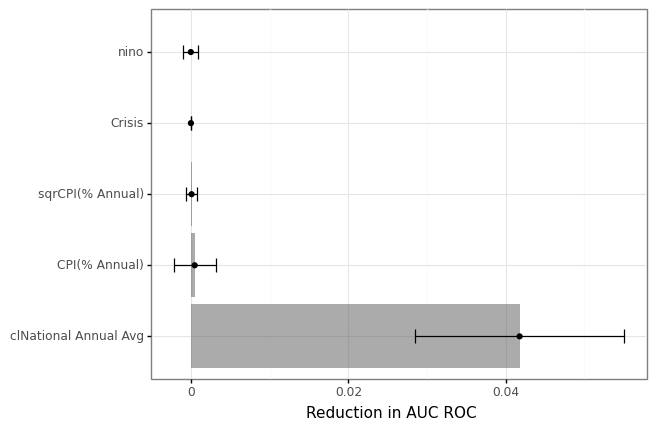

<ggplot: (167279768580)>

In [11]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

# Lessons
Data wrangling by far is the biggest challenge this project faces, generating enough observations and formatting tables to join together is significantly more difficult than the actual predictive leg of the work.

Moving forward I plan on incorporating the WVS data as well as cosidering to examine for outliers due to large variation in the y variable. Another possible solution for the y value is to create an annual change variable rather than an overall population amount. It may be worth reconsidering the scoring mechanism being used.

In [ ]:
#